In [92]:
 import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

 Regression Analysis: Seasonal Effects with Sklearn Linear Regression

In [93]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("../HW10-TimeSeries/yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [94]:
 # Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


 Data Preparation

Returns

In [95]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
yen_futures['Return'] = yen_futures.Settle.pct_change() * 100
yen_returns = yen_futures.replace(-np.inf, np.nan).dropna()
yen_returns.tail()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Return
Date,,,,,,,,,
2019-10-09,9381.0,9391.5,9330.5,9343.5,38.5,9338.0,99153.0,145470.0,-0.410601
2019-10-10,9343.5,9380.5,9293.5,9301.0,34.5,9303.5,159397.0,144474.0,-0.369458
2019-10-11,9308.5,9309.0,9240.0,9267.0,52.5,9251.0,158810.0,147471.0,-0.564304
2019-10-14,9259.0,9292.0,9250.5,9261.0,14.0,9265.0,69457.0,153902.0,0.151335
2019-10-15,9264.5,9280.0,9216.5,9220.0,43.5,9221.5,108342.0,151564.0,-0.469509


Lagged Returns

In [96]:
# Create a lagged return using the shift function
yen_futures['Lagged Return'] = yen_futures['Return'].shift()
yen_futures.dropna(inplace=True)
yen_futures.tail()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Return,Lagged Return
Date,,,,,,,,,,
2019-10-09,9381.0,9391.5,9330.5,9343.5,38.5,9338.0,99153.0,145470.0,-0.410601,0.170931
2019-10-10,9343.5,9380.5,9293.5,9301.0,34.5,9303.5,159397.0,144474.0,-0.369458,-0.410601
2019-10-11,9308.5,9309.0,9240.0,9267.0,52.5,9251.0,158810.0,147471.0,-0.564304,-0.369458
2019-10-14,9259.0,9292.0,9250.5,9261.0,14.0,9265.0,69457.0,153902.0,0.151335,-0.564304
2019-10-15,9264.5,9280.0,9216.5,9220.0,43.5,9221.5,108342.0,151564.0,-0.469509,0.151335


 Train Test Split

In [145]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = yen_futures[:'2018']
test = yen_futures['2018':]

In [146]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
X_train = train["Lagged Return"].to_frame()
X_test = test["Lagged Return"].to_frame()
Y_train = train["Return"]
Y_test = test["Return"]

In [147]:
X_train.dropna()

,Lagged Return
Date,
2014-02-18,0.409123
2014-02-19,-0.427829
2014-02-20,-0.020460
2014-02-21,0.020465
2014-02-24,-0.204604
...,...
2018-12-24,-0.187545
2018-12-26,0.834485
2018-12-27,-0.893346


Linear Regression Model

In [148]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = LinearRegression()
model.fit(X_train, Y_train).get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}

 Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

In [149]:
# Make a prediction of "y" values using just the test dataset
predictions = model.predict(X_test)

In [150]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = Y_test.to_frame()
Results["Predicted Return"] = predictions
Results.head(2)

,Return,Predicted Return
Date,,
2018-01-02,0.297285,-0.006707
2018-01-03,-0.240479,-0.007568


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000153B9FEB760>,
      dtype=object)

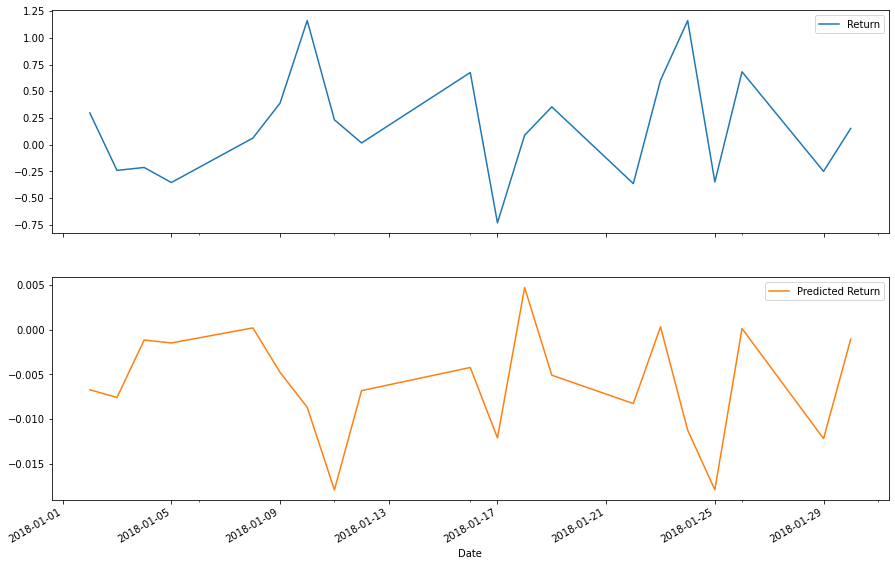

In [151]:
# Plot the first 20 predictions vs the true values
Results[:20].plot(subplots=True, figsize=(15,10))

 Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (X_test and y_test)

In [152]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y"
MSE = mean_squared_error(Results["Return"], Results["Predicted Return"])

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
RMSE = np.sqrt(MSE)
print(f"Out-of-Sample Root Mean Squared Error(RMSE): {RMSE}")

Out-of-Sample Root Mean Squared Error(RMSE): 0.4151933603075715


 In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [155]:
# Construct a dataframe using just the "y" training data:
in_sample_results = Y_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
in_sample_results["In-Sample Predictions"] = model.predict(X_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sample_MSE =  mean_squared_error(in_sample_results["Return"], in_sample_results["In-Sample Predictions"])

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_RMSE = np.sqrt(in_sample_MSE)
print(f"In-Sample Root Mean Squared Error(RMSE): {in_sample_RMSE}")

In-Sample Root Mean Squared Error(RMSE): 0.5657562717010388


 Conclusions

The Out-of-Sample data is the Testing data, in which the model has NOT seen before. 
The Out-of-Sample Root Mean Squared Error (RMSE) to the thousandth is 0.415.

The In-Sample data is the Training data, in which the model has seen before.
The In-Sample Root Mean Squared Error (RMSE) rounded to the thousandth is integ is 0.566.

Usually, the RMSE is lower for the training data. The training data(In-Sample data) is higher
than the test data(Out-of-Sample) in this case.
The testing data(Out-of-Sample), which the the model has not seen before, performs better than the training data(In-Sample).